# Islington Data Science Capstone

## Business Case

The business problem I am suggesting is that a friend wants to open a Pub in the Islington area of London. They want to know the most  popular restaurant venue types already in the area (including competitive pubs) and also when different types of restaurants are popular so that they can target their marketing and resources accordingly.

## Data Requirements

The data that I will need is a list of the restaurants and bars in the local area, the type of venue that they are, the times that they are open and the times that they are popular. I'll include data on other types of restaurants and bars so that my model learns about when food/drink venues are generally popular in the local area. Including data on other types of bars and restaurants will help to prevent my model from over-fitting. It may also highlight a gap in the market if there are other restaurants that are open and popular but existing pubs are not open.

### Venues in the area

Here, I use the foursquare API to find Venues in the islington area:

In [2]:
# Hardcode latitude and longitude
islington_lat = 51.5465
islington_long = -0.1058

In [52]:
# Load in foursquare credentials
cred_store = {}
with open('../secret.txt','r') as f:
    for line in f.read().split('\n'):
        cred_store[line.split('=')[0]] = line.split('=')[1]

print('Credentials saved:', cred_store.keys())

Credentials saved: dict_keys(['CLIENT_ID', 'CLIENT_SECRET', 'VERSION'])


In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import requests
%matplotlib inline


# Pinched from the tutorial but rigged up to use the correct credentials and search a single location
# max limit on the FS API is 50 - use that and iterate over locations
# Apparently 1 degree = 111 km, so we should iterate north, south, east and west by 500m = 0.0045 degrees in 
# each direction to build as full a picture as possible.

LIMIT = 500

def getNearbyVenues(latitude, longitude, radius=500, categories=[], n=0):
    assert len(categories)>0,'You must provide some categories'
    venues_list=[]
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        cred_store['CLIENT_ID'], 
        cred_store['CLIENT_SECRET'], 
        cred_store['VERSION'], 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        ','.join(categories)
        )
            
    # make the GET request
    r = requests.get(url).json()
    
    # Store the response
    with open('location_data_{}.json'.format(str(n)),'w') as f:
        json.dump(r, f)
    print('Saved results to location_data.json')
    return r

In [20]:
lat_long_combos = [
    (islington_lat, islington_long),
    (islington_lat + 0.0045, islington_long),
    (islington_lat - 0.0045, islington_long),
    (islington_lat, islington_long + 0.0045),
    (islington_lat, islington_long - 0.0045),
]
responses = []
for idx, ll_combo in enumerate(lat_long_combos):
    venues = getNearbyVenues(ll_combo[0], ll_combo[1], categories=[
        '4d4b7105d754a06374d81259',
        '4d4b7105d754a06376d81259',
    ], n=idx)
    responses.append(venues)
print('Completed getting data.')

Saved results to location_data.json
Saved results to location_data.json
Saved results to location_data.json
Saved results to location_data.json
Saved results to location_data.json
Completed getting data.


Now we need to merge the data on each of the responses:

In [21]:
list_of_venues = []
for response in responses:
    list_of_venues.extend(response['response']['venues'])
print(len(list_of_venues),'venues identified.')

250 venues identified.


In [22]:
# Look at a sample venue to figure out the response format:
print(list_of_venues[0])

{'id': '513918c7704366713f2fcc3d', 'name': 'The Coffee Run', 'location': {'address': 'Highbury & Islington Station', 'crossStreet': 'Highbury Corner', 'lat': 51.546000802132326, 'lng': -0.10456097809396134, 'labeledLatLngs': [{'label': 'display', 'lat': 51.546000802132326, 'lng': -0.10456097809396134}], 'distance': 102, 'postalCode': 'n5 1ra', 'cc': 'GB', 'city': 'London', 'state': 'Greater London', 'country': 'United Kingdom', 'formattedAddress': ['Highbury & Islington Station (Highbury Corner)', 'London', 'Greater London', 'n5 1ra', 'United Kingdom']}, 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}], 'venuePage': {'id': '53899327'}, 'referralId': 'v-1567330653', 'hasPerk': False}


Great, so we have information on the location of our venues and their categories - let's put it into a DataFrame.

In [24]:
venues_df = pd.DataFrame.from_records([
    {
        'id':v['id'],
        'name':v['name'],
        'lat':v['location']['lat'],
        'lng':v['location']['lng'],
        'category_id':v['categories'][0]['id'],
        'category_name':v['categories'][0]['name']
    } for v in list_of_venues
])
venues_df.head()

,category_id,category_name,id,lat,lng,name
0,4bf58dd8d48988d1e0931735,Coffee Shop,513918c7704366713f2fcc3d,51.546001,-0.104561,The Coffee Run
1,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon)
2,4bf58dd8d48988d1e0931735,Coffee Shop,4b9f4295f964a520181a37e3,51.545450,-0.103359,Starbucks
3,4bf58dd8d48988d1c5941735,Sandwich Place,5b72beda2b274a002c210b28,51.546034,-0.103308,Pret A Manger
4,4bf58dd8d48988d1e5931735,Music Venue,4ac518c8f964a5208ba520e3,51.546663,-0.104009,The Garage


### Venue Types - Exploratory Data Analysis

Let's take a look at the distribution of venue categories:

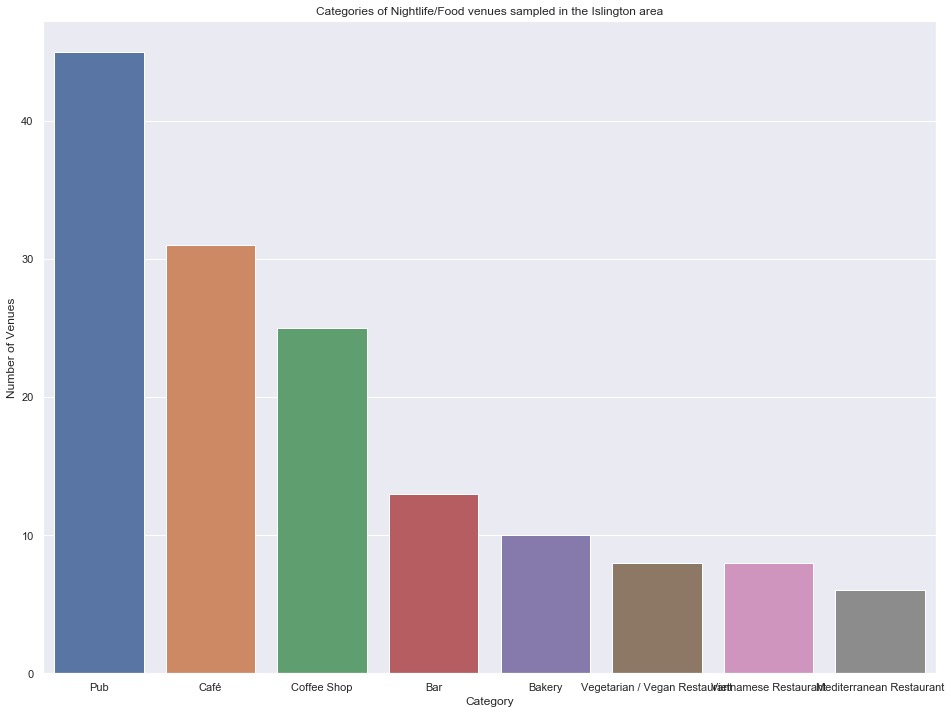

In [31]:
import seaborn as sns
plt.figure(1, figsize=(16, 12))
sns.set()
# Top 8 venue types
venue_types = venues_df.category_name.value_counts()[:8]
sns.barplot(venue_types.index, venue_types.values)
plt.title('Categories of Nightlife/Food venues sampled in the Islington area')
plt.xlabel('Category')
plt.ylabel('Number of Venues')
plt.show()

Wow, that's a lot of Pubs in the area! Let's visualise where they are:

In [67]:
# Set colors using bar/not pub

import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[islington_lat, islington_long], zoom_start=14)

colors_array = cm.rainbow(np.linspace(0, 1, 2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# # add markers to the map
# markers_colors = []
for lat, lon, category, venue_name, is_pub in zip(venues_df['lat'], venues_df['lng'], venues_df['category_name'],venues_df['name'], venues_df['category_name']=='Pub'):
    label = folium.Popup(str(category) + ' ' + venue_name, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[is_pub],
        fill=True,
        fill_color=rainbow[is_pub],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Venue Hours Data

Now, let's get data on the venues identified, and see when they are open and/or popular:

In [40]:
def get_venue_hours(venue_id=''):
    url = 'https://api.foursquare.com/v2/venues/{}/hours?client_id={}&client_secret={}&v={}'.format(
        venue_id,
        cred_store['CLIENT_ID'],
        cred_store['CLIENT_SECRET'],
        cred_store['VERSION']
    )
    r = requests.get(url)
    return r.json()
# Test on a sample venue_id
get_venue_hours('4b181b1bf964a520fecc23e3')

{'meta': {'code': 200, 'requestId': '5d6b9a3fbe707800395b98c4'},
 'response': {'hours': {'timeframes': [{'days': [1, 2, 3, 4, 5, 6, 7],
     'includesToday': True,
     'open': [{'start': '0800', 'end': '2300'}],
     'segments': []}]},
  'popular': {'timeframes': [{'days': [7],
     'includesToday': True,
     'open': [{'start': '1100', 'end': '2300'}],
     'segments': []},
    {'days': [1], 'open': [{'start': '1700', 'end': '2300'}], 'segments': []},
    {'days': [2], 'open': [{'start': '1700', 'end': '+0000'}], 'segments': []},
    {'days': [3], 'open': [{'start': '1700', 'end': '2300'}], 'segments': []},
    {'days': [4, 5],
     'open': [{'start': '1700', 'end': '+0000'}],
     'segments': []},
    {'days': [6],
     'open': [{'start': '1000', 'end': '+0000'}],
     'segments': []}]}}}

Ok, this will need quite a bit of wrangling to get into a position where we can do some analysis.

As a consequence, let's first write functions that build a list of all responses and dump them into a JSON file, so we don't max out our API credits:

In [ ]:
import time

def get_list_of_venue_hours(venue_ids=[]):
    list_of_responses = []
    for venue_id in venue_ids:
        try:
            r = get_venue_hours(venue_id)['response']
            print(r)
            # Store the venue_id so we can join it later
            r['venue_id'] = venue_id
            list_of_responses.append(r)
        except:
            continue
        finally:
            # Sleep a little while after
            time.sleep(0.5)
            
    with open('venue_open_hours.json','w') as f:
        json.dump(list_of_responses, f)
        
    return list_of_responses

venue_hours = get_list_of_venue_hours(venues_df.id)

In [60]:
venue_hours = json.load(open('venue_hours.json','r'))
# Filter for where we have valid records
venue_hours = [x for x in venue_hours if 'hours' in x and x['hours']!={}]
len(venue_hours)

32

Ok, now we have the venue hours for 32 of our venues - we are missing opening hours and/or popular hours for some due to API limits and missing data, but we can get these later if we need to.

For now we'll wrangle the data in order to make our time series dataset.

### Data Wrangling - Opening/Popular Hours

Here, we want to develop records for every hour that a given venue is open, categorising it as popular or not. We will include features for pub/not, nightlife venue/not, and the time we are classifying against.

In [66]:
venue_hours[4]

{'hours': {'timeframes': [{'days': [1, 2, 3, 4, 5, 6],
    'open': [{'start': '1100', 'end': '2300'}],
    'segments': []},
   {'days': [7],
    'includesToday': True,
    'open': [{'start': '1200', 'end': '2200'}],
    'segments': []}]},
 'popular': {'timeframes': [{'days': [7],
    'includesToday': True,
    'open': [{'start': '1200', 'end': '2200'}],
    'segments': []},
   {'days': [1],
    'open': [{'start': '1200', 'end': '1500'},
     {'start': '1800', 'end': '2200'}],
    'segments': []},
   {'days': [2],
    'open': [{'start': '1200', 'end': '1300'},
     {'start': '1800', 'end': '2300'}],
    'segments': []},
   {'days': [3],
    'open': [{'start': '1200', 'end': '1300'},
     {'start': '1800', 'end': '2100'}],
    'segments': []},
   {'days': [4],
    'open': [{'start': '1200', 'end': '1400'},
     {'start': '1800', 'end': '2300'}],
    'segments': []},
   {'days': [5, 6],
    'open': [{'start': '1300', 'end': '1500'},
     {'start': '1700', 'end': '2200'}],
    'segments': 

In [88]:
def contained_within(day, hour, segments):
    # Check whether an hour on a day is contained within either the open hours or the popular hours sub-objects.
    hours = [x for x in segments['timeframes'] if day in x['days']][0]['open']
    if any([time_range['start'] <= hour and time_range['end'] >= hour for time_range in hours]):
        return True
    return False

# contained_within(1, '1800', venue_hours[4]['hours'])

def extract_hours(venue_hours):
    open_hours = venue_hours['hours']['timeframes']
    # Days are as numbers - 1 to 7
    days = list(range(1,8))
    # Have some realistic possible times for opening - 9AM to 11PM
    hours = [('0'+str(n * 100))[-4:] for n in range(9,24)]
    hour_stats = []
    for day in days:
        for hour in hours:
            val = {
                'venue_id':venue_hours['venue_id'],
                'day':day,
                'hour':hour,
                'is_open': contained_within(day, hour, venue_hours['hours']),
                'is_popular':contained_within(day, hour, venue_hours['popular'])
            }
            hour_stats.append(val)
    return hour_stats

In [95]:
hours_data = []
for idx,venue in enumerate(venue_hours):
    print(idx, end='\r')
    # Some will fail due to missing popular hours - skip them.
    try:
        hours_data.extend(extract_hours(venue))
    except:
        continue
hours_df = pd.DataFrame(hours_data)
hours_df.head()

,day,hour,is_open,is_popular,venue_id
0,1,0900,True,False,4b181b1bf964a520fecc23e3
1,1,1000,True,False,4b181b1bf964a520fecc23e3
2,1,1100,True,False,4b181b1bf964a520fecc23e3
3,1,1200,True,False,4b181b1bf964a520fecc23e3
4,1,1300,True,False,4b181b1bf964a520fecc23e3


Let's have a basic look at when venues are generally popular:

In [103]:
hours_df[hours_df.is_open == True].groupby(['day','hour']).is_popular.mean()

day  hour
1    0900    0.625000
     1000    0.666667
     1100    0.428571
     1200    0.529412
     1300    0.555556
     1400    0.555556
     1500    0.470588
     1600    0.277778
     1700    0.333333
     1800    0.611111
     1900    0.866667
     2000    0.866667
     2100    0.733333
     2200    0.615385
     2300    0.300000
2    0900    0.625000
     1000    0.444444
     1100    0.357143
     1200    0.470588
     1300    0.555556
     1400    0.388889
     1500    0.235294
     1600    0.222222
     1700    0.277778
     1800    0.666667
     1900    0.933333
     2000    0.800000
     2100    0.666667
     2200    0.769231
     2300    0.800000
               ...   
6    0900    0.875000
     1000    0.888889
     1100    0.666667
     1200    0.769231
     1300    0.923077
     1400    0.923077
     1500    0.916667
     1600    0.833333
     1700    0.916667
     1800    0.666667
     1900    0.700000
     2000    0.500000
     2100    0.400000
     2200    0.555556


So venues are mostly popular earlier in the weekends (1400 - 2000) and on weekdays in the evenings (1900 - 2300). That makes sense, as it's when there are more customers generally around.

Let's check how many samples there are:

In [104]:
hours_df.shape

(2205, 5)

In [107]:
full_dataset = hours_df.merge(venues_df, left_on='venue_id',right_on='id')
full_dataset.shape

(7455, 11)

Looks like there are some duplicates in the dataset - let's drop them.

In [109]:
full_dataset.drop_duplicates(inplace=True)

In [110]:
full_dataset.head()

,day,hour,is_open,is_popular,venue_id,category_id,category_name,id,lat,lng,name
0,1,0900,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon)
4,1,1000,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon)
8,1,1100,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon)
12,1,1200,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon)
16,1,1300,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon)


Let's find out when Pubs are generally popular, according to our sample:

In [121]:
pub_times_aggs = full_dataset[full_dataset.category_name=='Pub']
popular_pub_times = pub_times_aggs.groupby(['day','hour']).is_popular.mean()
popular_pub_times[popular_pub_times > 0.5]

day  hour
1    1700    0.6
     1800    1.0
     1900    1.0
     2000    1.0
     2100    1.0
2    1800    0.8
     1900    0.8
     2000    0.8
     2100    0.8
     2200    0.8
     2300    0.8
3    1700    0.6
     1800    0.8
     1900    0.8
     2000    0.8
     2100    0.8
     2200    0.8
7    1300    0.6
     1400    0.8
     1500    1.0
     1600    1.0
     1700    1.0
     1800    1.0
     1900    1.0
     2000    1.0
     2100    1.0
     2200    0.6
Name: is_popular, dtype: float64

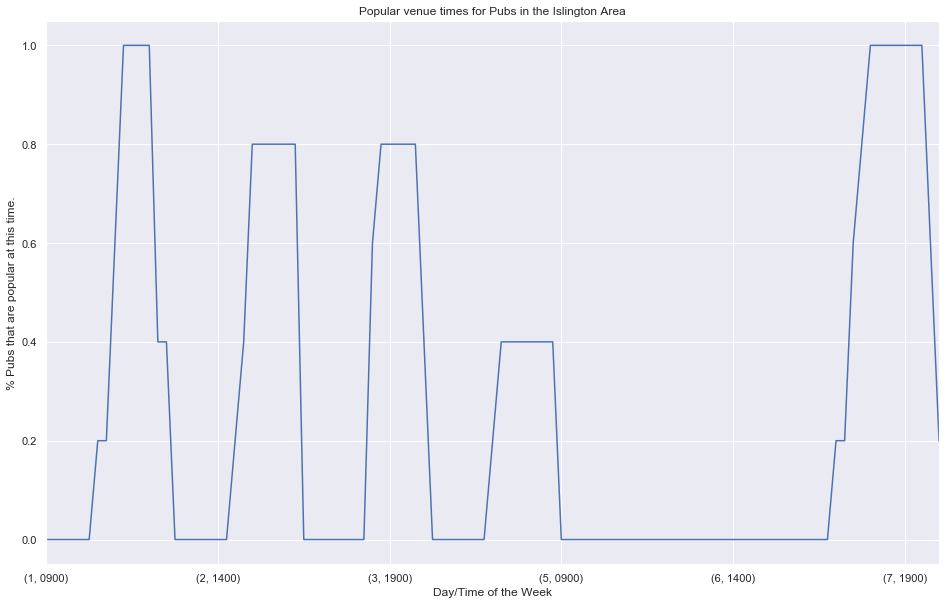

In [124]:
plt.figure(1, figsize=(16, 10))
popular_pub_times.plot(kind='line')
plt.title('Popular venue times for Pubs in the Islington Area')
plt.xlabel('Day/Time of the Week')
plt.ylabel('% Pubs that are popular at this time.')
plt.show()

So it looks like the popular pub times in Islington are generally Mondays, Tuesdays and Wednesdays from 6-9PM, and Sundays from 2PM to 9PM.

## Model building

Let's build a simple random forest model to predict whether a Venue will be popular or not at a given hour.

The features will be:
* Venue type: is_pub, is_cafe, is_coffee_shop - these are the top types, and different types of venue will be popular at different hours.
* Venue: is_bar - this is the parent category of pub; all non-pub bars contain ' Bar' in the category name so we'll use this.
* Day of the Week (1-7)
* Hour of the day (9-23)

We'll train a decision tree classifier to predict when pub venues will be popular on an 80% sample, gain metrics on its accuracy using a 20% sample; and use this model to predict against all time ranges in order to determine when peak hours for Islington pubs will be.

In [126]:
df = full_dataset.copy()

In [132]:
# Add manual features
df['is_pub'] = df.category_name == 'Pub'
df['is_bar'] = df.category_name.str.contains(' Bar')
df['is_cafe'] = df.category_name == 'Cafe'
df['is_coffee_shop'] = df.category_name == 'Coffee Shop'
df.head()

,day,hour,is_open,is_popular,venue_id,category_id,category_name,id,lat,lng,name,is_pub,is_bar,is_cafe,is_coffee_shop
0,1,0900,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon),True,False,False,False
4,1,1000,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon),True,False,False,False
8,1,1100,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon),True,False,False,False
12,1,1200,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon),True,False,False,False
16,1,1300,True,False,4b181b1bf964a520fecc23e3,4bf58dd8d48988d11b941735,Pub,4b181b1bf964a520fecc23e3,51.545746,-0.103161,The White Swan (Wetherspoon),True,False,False,False


In [134]:
# Drop non-features
df.drop(['venue_id','category_id','category_name','id','lat','lng','name'], axis=1, inplace=True)

In [153]:
# Encode hours as numerics
hours = [('0'+str(n * 100))[-4:] for n in range(9,24)]
hour_labels = {hour:idx for idx,hour in enumerate(hours)}
df['hour_encoded'] = df.hour.replace(to_replace=hour_labels,)
df.drop('hour',axis=1,inplace=True)
df.head()

,day,is_open,is_popular,is_pub,is_bar,is_cafe,is_coffee_shop,hour_encoded
0,1,True,False,True,False,False,False,0
4,1,True,False,True,False,False,False,1
8,1,True,False,True,False,False,False,2
12,1,True,False,True,False,False,False,3
16,1,True,False,True,False,False,False,4


In [154]:
X = df[['day','is_open','is_pub','is_bar','is_cafe','is_coffee_shop','hour_encoded']]
y = df[['is_popular']]
X.shape, y.shape

((2205, 7), (2205, 1))

Create a 80:20 train/test split

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [156]:
X_train.shape, y_train.shape

((1764, 7), (1764, 1))

In [164]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier()
print(DTC.fit(X_train, y_train.values).score(X_train, y_train))

0.86281179138322


In [169]:
from sklearn.metrics import f1_score
f1_train = f1_score(y_train, DTC.predict(X_train))
f1_test = f1_score(y_test, DTC.predict(X_test))
f1_train, f1_test

(0.8342465753424656, 0.7377049180327868)

In [172]:
list(zip(DTC.feature_importances_, X.columns))

[(0.14509847492126715, 'day'),
 (0.4590119827377251, 'is_open'),
 (0.054354337783886195, 'is_pub'),
 (0.01763711497900008, 'is_bar'),
 (0.0, 'is_cafe'),
 (0.02335618998627867, 'is_coffee_shop'),
 (0.30054189959184274, 'hour_encoded')]

Getting an 83% train f1 and a 73% test f1 is very good! It also makes sense that primary features would be whether the venue is open (it can't be popular if it isn't!) and the date/time. This also bodes well for our use case, as the features are clearly related to popularity.

### The kernel crashed here - reloading files below

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

C:\Users\Julia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from sklearn.tree import DecisionTreeClassifier
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

DTC = DecisionTreeClassifier()
print(DTC.fit(X_train, y_train.values).score(X_train, y_train))

from sklearn.metrics import f1_score
f1_train = f1_score(y_train, DTC.predict(X_train))
f1_test = f1_score(y_test, DTC.predict(X_test))
print(f1_train, f1_test)

print(list(zip(DTC.feature_importances_, X.columns)))

C:\Users\Julia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.86281179138322
0.8342465753424656 0.7397260273972603
[(0.14394203118061125, 'day'), (0.45901198273772514, 'is_open'), (0.0543543377838862, 'is_pub'), (0.018022540565022612, 'is_bar'), (0.0, 'is_cafe'), (0.023356189986278673, 'is_coffee_shop'), (0.3013129177464761, 'hour_encoded')]


### Continued

Let's try logistic regression as a comparator:

In [9]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
print(logreg.fit(X_train, y_train['is_popular'].values).score(X_train, y_train['is_popular'].values))

0.7670068027210885


C:\Users\Julia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [10]:
f1_train = f1_score(y_train.is_popular.values, logreg.predict(X_train))
f1_test = f1_score(y_test.is_popular.values, logreg.predict(X_test))

In [11]:
f1_train, f1_test

(0.7516616314199396, 0.7410926365795724)

This is nowhere near as good a result, and that's to be expected given that the function we are trying to map is less likely to be continuous and therefore suited to decision trees/Support Vector Machines. Let's try an SVC:

In [15]:
from sklearn.svm import SVC
for n in [0.01,0.03, 0.1,0.3,1.0,3.0,10.0]:
    # Search for optimal C
    svc = SVC(kernel='rbf',random_state=42,probability=True,gamma='auto', C=n)
    print(
        n,
        svc.fit(X_train, y_train.is_popular.values).score(X_train, y_train.is_popular.values),
        f1_score(y_test.is_popular.values, svc.predict(X_test))
    )

C:\Users\Julia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01 0.5856009070294784 0.0
0.03 0.6655328798185941 0.3605150214592275
0.1 0.780045351473923 0.6787878787878788
0.3 0.8208616780045351 0.7948051948051947
1.0 0.8339002267573696 0.8
3.0 0.8429705215419501 0.8062015503875969
10.0 0.8497732426303855 0.7916666666666665


In [16]:
# Go with c of 3.0:
svc = SVC(kernel='rbf',random_state=42,probability=True,gamma='auto', C=3.0)
svc.fit(X_train, y_train.is_popular.values).score(X_train, y_train.is_popular.values)

0.8429705215419501

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.is_popular.values, svc.predict(X_test))

array([[210,  43],
       [ 32, 156]], dtype=int64)

In [22]:
from sklearn.metrics import precision_score, recall_score
print(
    precision_score(y_test.is_popular.values, svc.predict(X_test)),
    recall_score(y_test.is_popular.values, svc.predict(X_test))
)

0.7839195979899497 0.8297872340425532


This is a pretty good confusion matrix to be seeing: we're getting balanced T/F predictions, with an 80.6% f1 score as noted earlier. The precision and recall are well balanced at 78.4% and 83.0% (i.e. not just predicting one class or the other).

Now, let's use the classifier to predict when is good for a pub to be open by generating dummy data:

In [23]:
dummy_rows = []

# Encode hours as numerics
hours = [('0'+str(n * 100))[-4:] for n in range(9,24)]
hour_labels = {hour:idx for idx,hour in enumerate(hours)}

for day in range(1,8):
    # Have some realistic possible times for opening - 9AM to 11PM
    for hour in [('0'+str(n * 100))[-4:] for n in range(9,24)]:
        dummy_rec = {
            'day':day,
            'is_open':True,
            'is_pub':True,
            'is_bar':False,
            'is_cafe':False,
            'is_coffee_shop':False,
            'hour_encoded':hour_labels[hour]
        }
        
        dummy_rows.append(dummy_rec)

dummy_X = pd.DataFrame(dummy_rows)
dummy_X

,day,hour_encoded,is_bar,is_cafe,is_coffee_shop,is_open,is_pub
0,1,0,False,False,False,True,True
1,1,1,False,False,False,True,True
2,1,2,False,False,False,True,True
3,1,3,False,False,False,True,True
4,1,4,False,False,False,True,True
5,1,5,False,False,False,True,True
6,1,6,False,False,False,True,True
7,1,7,False,False,False,True,True
8,1,8,False,False,False,True,True
9,1,9,False,False,False,True,True


In [26]:
# Ensure the correct column orders and predict. 
dummy_pred = dummy_X.copy()[X.columns]
dummy_pred['prediction'] = svc.predict_proba(dummy_X)[:,0]
dummy_pred

,day,is_open,is_pub,is_bar,is_cafe,is_coffee_shop,hour_encoded,prediction
0,1,True,True,False,False,False,0,0.547583
1,1,True,True,False,False,False,1,0.108821
2,1,True,True,False,False,False,2,0.046148
3,1,True,True,False,False,False,3,0.100461
4,1,True,True,False,False,False,4,0.342903
5,1,True,True,False,False,False,5,0.626348
6,1,True,True,False,False,False,6,0.746624
7,1,True,True,False,False,False,7,0.779557
8,1,True,True,False,False,False,8,0.786769
9,1,True,True,False,False,False,9,0.787972


In [27]:
# Get back the original labels for the hours:
hours = [('0'+str(n * 100))[-4:] for n in range(9,24)]
hour_inverse = {idx:hour for idx,hour in enumerate(hours)}

dummy_pred['hour'] = dummy_pred.hour_encoded.replace(hour_inverse)
dummy_pred.head()

,day,is_open,is_pub,is_bar,is_cafe,is_coffee_shop,hour_encoded,prediction,hour
0,1,True,True,False,False,False,0,0.547583,0900
1,1,True,True,False,False,False,1,0.108821,1000
2,1,True,True,False,False,False,2,0.046148,1100
3,1,True,True,False,False,False,3,0.100461,1200
4,1,True,True,False,False,False,4,0.342903,1300


In [28]:
# Clean up dummy_pred:
dummy_pred.drop(['is_open','is_pub','is_bar','is_cafe','is_coffee_shop','hour_encoded'], axis=1, inplace=True)
dummy_pred

,day,prediction,hour
0,1,0.547583,0900
1,1,0.108821,1000
2,1,0.046148,1100
3,1,0.100461,1200
4,1,0.342903,1300
5,1,0.626348,1400
6,1,0.746624,1500
7,1,0.779557,1600
8,1,0.786769,1700
9,1,0.787972,1800


Now let's find the most and least likely hours for our pub to be successful according to the model:

In [31]:
dummy_pred.sort_values('prediction')[-10:]

,day,prediction,hour
13,1,0.788136,2200
74,5,0.788136,2300
89,6,0.788136,2300
59,4,0.788136,2300
44,3,0.788136,2300
104,7,0.788136,2300
29,2,0.788136,2300
14,1,0.788136,2300
75,6,0.824772,0900
90,7,0.842901,0900


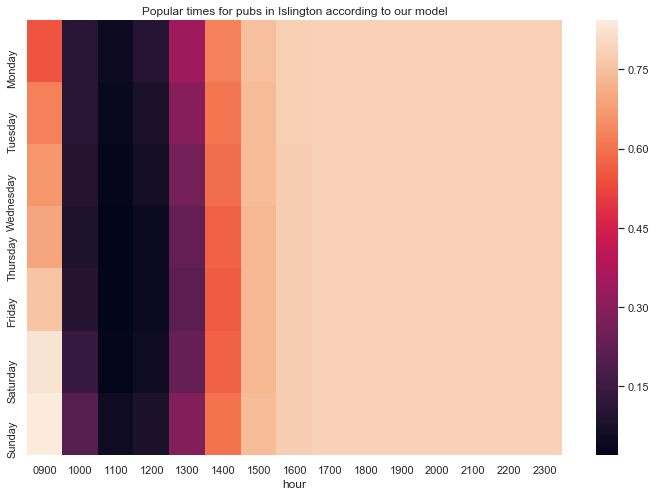

In [47]:
heatmap = dummy_pred.pivot(index='day',columns='hour',values='prediction')
heatmap.index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(1,figsize=(12,8))
import seaborn as sns
plt.title('Popular times for pubs in Islington according to our model')
plt.xlabel('Hour')
plt.ylabel('Day of the week')
sns.set()
sns.heatmap(heatmap)

In [48]:
heatmap

hour,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
Monday,0.547583,0.108821,0.046148,0.100461,0.342903,0.626348,0.746624,0.779557,0.786769,0.787972,0.788122,0.788135,0.788136,0.788136,0.788136
Tuesday,0.626085,0.108206,0.036050,0.077020,0.301856,0.607638,0.741825,0.778585,0.786613,0.787954,0.788120,0.788135,0.788136,0.788136,0.788136
Wednesday,0.665456,0.098766,0.027213,0.058875,0.265782,0.589901,0.737406,0.777706,0.786473,0.787937,0.788118,0.788135,0.788136,0.788136,0.788136
Thursday,0.695773,0.085814,0.019742,0.043908,0.230987,0.571070,0.732797,0.776800,0.786330,0.787919,0.788117,0.788135,0.788136,0.788136,0.788136
Friday,0.758297,0.096209,0.018860,0.039651,0.217042,0.561992,0.730459,0.776327,0.786254,0.787910,0.788116,0.788135,0.788136,0.788136,0.788136
Saturday,0.824772,0.140326,0.026374,0.048477,0.234205,0.570475,0.732295,0.776657,0.786303,0.787916,0.788117,0.788135,0.788136,0.788136,0.788136
Sunday,0.842901,0.208802,0.048350,0.078519,0.290270,0.598603,0.739045,0.777965,0.786508,0.787940,0.788119,0.788135,0.788136,0.788136,0.788136


Interesting - so overall our model sees late evenings (around 1700 onwards) as the most popular times for pubs to be open; with 2300 being most popular. However, unexpectedly, it also sees 9AM as fairly popular; and weekends as fairly popular after 3PM. 

## Conclusion:

As a consequence of our investigation, we recommend that our friends should keep their pub fully staffed from 5PM until at least 11PM and fully staffed from 3PM on weekdays in order to maximise staffing when the pub is most popular.